# Convolutional Neural Networks on Image Classification

### Links usados

- https://towardsdatascience.com/detecting-pneumonia-using-convolutional-neural-network-599aea2d3fc9
- https://www.tensorflow.org/tutorials/images/classification#visualize_the_data
- https://towardsdatascience.com/beginners-guide-to-building-convolutional-neural-networks-using-tensorflow-s-keras-api-in-python-6e8035e28238
- https://medium.com/analytics-vidhya/how-to-use-autokeras-to-build-image-classification-models-using-one-line-of-code-c35b0c36e66e

### Part 1 - Building the CNN

#### Importing the Tensorflow libraries and packages

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# -------------------------------------
import matplotlib.pyplot as plt
import numpy as np

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### Build the CNN Model

##### Architecture:
- Step 1 - Convolution2D + MaxPooling layer
    - Arguments: input_shape (64,64,3), 32 filters, 3x3 kernel, relu activation
- Step 2.1-2.n - Adding new "n" Convolution2D + MaxPooling layer (more layers = more parameters = more complexity - care overfit)
- Step 3 - Flattening
- Step 4.1 - 4.n - Dense Layer
    - Arguments: 128 units, relu activation
- Step 5 - Output Layer (Dense Layer with units = 1, sigmoid activation)

In [19]:
classifier = Sequential()

# Step 1 - Convolution + MaxPooling layer
# Arguments: 32 filters, 3x3 kernel, relu activation
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 2 - Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

#### Compiling the CNN
- optimizer = 'adam'
- loss = 'binary_crossentropy' - binary problem (either cat or dog)
- metrics = ['accuracy', ...]

In [20]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Part 2 - Fitting the CNN to the images

- Step 1 - ImageDataGenerator class for data train and test data generation
    - Arguments: Rescale, shear_range, zoom_range, horizontal_flip
    - For test dataset, only rescale is required

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

- Step 2 - ImageDataGenerator class - use the "flow_from_directory" function to read the input dataset and prepare for augmentation
    - Arguments: directory, target_size, batch_size, class_mode='binary'

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


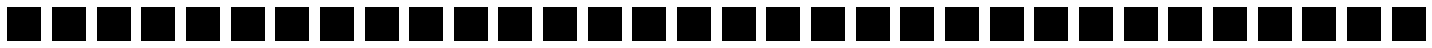

[124. 247. 226. 157. 240. 121.   6.  18. 226. 151. 207. 183. 188.  90.
 156.  28. 222. 191. 122. 163. 209.  20.  31.  40. 121.  26.  95. 234.
  82. 118. 113. 153.]


In [28]:
training_set = train_datagen.flow_from_directory('dataset/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 32, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

imgs, labels = next(training_set)
plotImages(imgs)
print(labels)

- Step 3 - fit the model using "fit_generator" function
    - Arguments: training_dataset, steps_per_epoch, epochs, validation_data, validation_steps
    
- NOTE: install pillow package using "pip install pillow" or "conda install pillow"

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime

es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# Create a TensorBoard callback
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir = logs,
                          histogram_freq = 1,
                          profile_batch = '500,520')

classifier.fit_generator(training_set,
                         steps_per_epoch = training_set.samples / 32, # 8000 cases / 32 cases per batch (batch_size) = 250
                         epochs = 25, # play with number of epochs and benchmark results
                         callbacks = [es, mc, tensorboard],
                         validation_data = test_set,
                         validation_steps = 62, # 2000 cases / 32 cases per batch (batch_size) = 62.5
                         workers = 4) 

Epoch 1/25
  53/1100 [>.............................] - ETA: 1:24 - loss: 0.0000e+00 - accuracy: 0.0028

KeyboardInterrupt: 

### Part 3 - Making new model predictions for human validation
#### Using the trained model, use images located in dataset/single_prediction folder to verify it's performance

In [8]:
import numpy as np
from keras.preprocessing import image

test_image = image.load_img('dataset/single_prediction/cat_or_dog_1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
    
print(prediction)

dog
